## Completion of SEIR Project

At this point, you should have a working method of bringing your observations of deaths into agreement with your model. Broadly speaking, this software will:

* Import data on the deaths per week and the populations of each state in the US.
* Run an SEIRD model and provide comparisons between model output and data at the appropriate dates. This comparison results in sum square error or SSE for the run.
* Use Powell's method followed by the simplex method in order to minimize the SSE for some set of parameters that consists of the 7 coefficients describing a sixth order polynomial approximation of $\beta(t)$ and a scalar valued death rate. 
* This should be done for each state and the optimal set of coefficients saved to a file.

Going forward, it may be helpful to acquire additional data, or compute additional information. So ideas are:

* The $R_o$ is generally easier to think about than the $\beta(t)$. It is just the product $\beta(t) \gamma$ and tells you the number of cases resulting from a case. If it is less than 1 the number of cases is decreasing.
* The initial weeks of the infection probably reveal an $R_o$ that reflects what happens when people are taking no precautions to reduce the spread. Capture this data.
* $1 - \frac{1}{R_o}$ is the herd immunity threshold. Beyond this point of infection or vaccination or infection in the population, we expect the number of new cases to decline to zero. Find this using the $R_o$ that you think corresponds to pre-pandemic levels of interaction between people.
* It might be interesting to collect the so-called 'excess deaths' and compare them to the observed deaths as a basic check on under/over reporting.
* It's fairly easy to get data on vaccinations too.

To complete the analysis, the following additional need to be completed and questions answered:

1. Write code to create a `pandas` data frame containing relevant information from your simulations. This is going to be simulation output, as well as some of the processed data that is cited above.
2. Plot several fields from your simulation results using `geopandas`. This will require you to merge your data frame with one containing the geometric information of each state. Example code appears below.
3. Identify three states that you believe are outliers in terms of the dynamics.
4. Speculate on the reasons some states are outliers. Provide support in terms of data.
5. Based on your speculations in the previous problem, provide a numerical estimate of the uncertainty in key parameters using MCMC.
6. State 3 conclusions you can reach from completing this exercise. Base at least one on the idea that:
$$f_v = \frac{f_h-f_i}{1-f_i}$$
where $f_v$ is the fraction requiring vaccination, $f_i$ is the fraction that has been infected, and $f_h$ is the fraction required to reach heard immunity.


## Conclusion
I am sorry Jesse. After spending over 30 hours on this problem, I conclude that I am incapable of solving it.
The optimization is very sensitive to initial conditions of the polynomial coefficients and reaches different solutions depending on these initial conditions.
This suggests that the objective function is non-convex and that the simplex algorithms do not do well with local minima.
Other optimization techniques are recommended. Alternatively, a better student is required. More likely the latter.

I also can not figure out why the people are not conserved in the population plot after optimization.
The resulting beta values are very low but that still should not result in this behavior.
I am at a loss.

Perhaps if you have some time next week, we could look at this together.

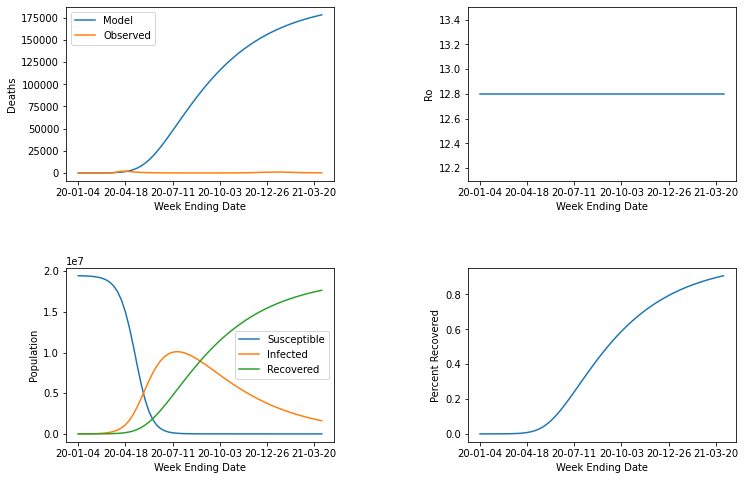

Optimization terminated successfully.
         Current function value: 15952596.030299
         Iterations: 2289
         Function evaluations: 3474


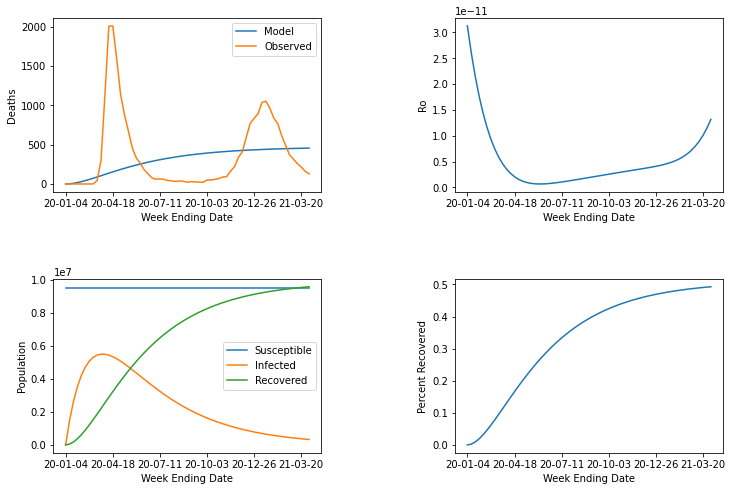

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import scipy.integrate as ODE
import pandas as pd
import numpy as np

class SEIR_ODE:
    def __init__(self, state):
        self.beta = 0.8   # infectiousness of infected person, overridden in function calls
        self.q = 0.5        # infectiousness of exposed person
        self.delta = 6      # time of exposure to infection
        self.gama = 16      # recovery rate
        self.omega = 0.01   # death rate, overridden in function calls
        self.N = None     # set in set_location()
        self.init_infect = 0.001

        self.beta_func = None   # set when state is chosen
        self.params = None      # set when state is chosen

        self.data_file = "Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv"
        self.data = self.read_data()
        self.population_data = pd.read_csv("Population.csv")[["Area", "2019"]]
        self.state_data = self.set_location(state)

        # model outputs
        self.model_deaths = None
        self.observed_deaths = None
        self.ODE_output = None


    def set_parameters(self, param_dict):
        self.beta = param_dict["beta"] if param_dict["beta"] is not None else self.beta
        self.q = param_dict["q"] if param_dict ["q"] is not None else self.q
        self.delta = param_dict["delta"] if param_dict["delta"] is not None else self.delta
        self.gama = param_dict["gama"] if param_dict["gama"] is not None else self.gama
        self.omega = param_dict["omega"] if param_dict["omega"] is not None else self.omega
        self.N = param_dict["N"] if param_dict["N"] is not None else self.N

        return None

    def SEIR(self, t, y):
        """
        Accepts the state of the system as:
        y[0] = Suseptable population - never impacted by the disease
        y[1] = Exposed population - has the disease, but not yet manifesting symptoms
        y[2] = Infected population - has the disease, and symptoms
        y[3] = Recovered population - has recovered from the disease, and is no longer suseptable
        y[4] = Dead population - recovered in the form of death

        This function returns the time deriviative of the state, dydt, and uses a dictionary
        of parameters p.
        """


        S, E, I, R, D = y
        beta = self.beta_func(t)
        d_S = -beta * S * (I + self.q * E) / self.N
        d_E = beta * S * (I + self.q * E) / self.N - E / self.delta
        d_I = E / self.delta - I / self.gama
        d_R = (1 - self.omega) * I / self.gama
        d_D = self.omega * I / self.gama

        return np.array((d_S, d_E, d_I, d_R, d_D))

    def read_data(self):
        raw_data = pd.read_csv(self.data_file, parse_dates=["Week Ending Date"])
        death_data = raw_data[["Week Ending Date", "COVID-19 Deaths", "State"]].dropna()

        return death_data

    def set_location(self, state):
        filtered_state_data = self.data.where(self.data["State"] == state).dropna()

        x = np.arange(len(filtered_state_data["COVID-19 Deaths"].values))
        y = np.full(x.shape, self.beta)
        self.beta_func = np.polynomial.polynomial.Polynomial.fit(x, y, deg=6, domain=[0, len(x)])

        self.params = self.beta_func.coef.copy()
        self.params = np.append(self.beta_func.coef, self.omega)
        self.params = np.append(self.params, self.init_infect)

        row = self.population_data.loc[self.population_data["Area"] == f".{state}"]
        self.N = int(row["2019"].values[0].replace(",", ""))

        return filtered_state_data

    def ODE_forward(self):

        # get number of time points
        time_final = self.state_data.shape[0]
        eval_points = np.arange(time_final)

        # initialize the populations
        ode_state = np.array((self.N * (1 - self.init_infect), self.init_infect * self.N, 0, 0, 0))

        # run the ode solver
        model_pred = ODE.solve_ivp(self.SEIR, (0, time_final), ode_state, t_eval=eval_points)

        return model_pred


    def get_SSE(self, params):
        """
        The hardest working routine - will
        1. accept a set of parameters for the polynomial coefficients and the death rate
        2. run the SEIR model using the ODE solver, solve_ivp
        3. return an Sum Square Error by comparing model result to data.
        :param params: 7 params for polynomial and 1 for death rate 1 for initial exposed population percentage
        :return:
        """
        # get number of time points
        time_final = self.state_data.shape[0]
        eval_points = np.arange(time_final + 1)

        # unpack parameters, set beta and omega class members
        self.beta_func.coef = params[:7].copy()
        self.beta = self.beta_func(eval_points)
        self.omega = params[7]
        self.init_infect = params[8]

        if np.any(self.beta <= 0):
            return 1e26
        if self.omega < 0 or self.omega > 1:
            return 1e26

        self.ODE_output = self.ODE_forward()
        self.model_deaths = self.ODE_output.y[4,:]

        self.observed_deaths = self.state_data['COVID-19 Deaths'].values

        SSE = np.sum(np.square(self.observed_deaths - self.model_deaths))
        return SSE

        # if self.observed_deaths.size == self.model_deaths.size:
        #     SSE = np.sum(np.square(self.observed_deaths - self.model_deaths))
        #     return SSE
        # else:
        #     return 1e26


    def plot_results(self):
        """
        create a 4 panel plot with the following views:

        * Deaths modeled and deaths observed as a function of time.
        * 𝑅𝑜  as a function of time.
        * The susceptable, infected and recovered populations as a function of time.
        * The fraction of the population that has recovered as a function time.
        """

        date_times = self.state_data["Week Ending Date"].values
        x = [np.datetime_as_string(date)[2:10] for date in date_times]

        fig = plt.figure(figsize=(12,8))
        gs = fig.add_gridspec(2,2, wspace=0.5, hspace=0.5)
        axs = gs.subplots()


        axs[0][0].set(xlabel="Week Ending Date", ylabel="Deaths")
        axs[0][0].plot(x, self.ODE_output.y[4, :], label="Model")
        axs[0][0].plot(x, self.observed_deaths, label="Observed")
        axs[0][0].set_xticks(x[::12])
        axs[0][0].legend()

        axs[0][1].set(xlabel="Week Ending Date", ylabel="Ro")
        axs[0][1].plot(x, self.beta_func(np.arange(len(x))) * self.gama)
        axs[0][1].set_xticks(x[::12])

        axs[1][0].set(xlabel="Week Ending Date", ylabel="Population")
        axs[1][0].plot(x, self.ODE_output.y[0, :], label="Susceptible")
        axs[1][0].plot(x, self.ODE_output.y[2, :], label="Infected")
        axs[1][0].plot(x, self.ODE_output.y[3, :], label="Recovered")
        axs[1][0].set_xticks(x[::12])
        axs[1][0].legend()


        axs[1][1].set(xlabel="Week Ending Date", ylabel="Percent Recovered")
        axs[1][1].plot(x, self.ODE_output.y[3, :]/self.N, label="Recovered")
        axs[1][1].set_xticks(x[::12])

        plt.show()

        return None

    def optimize(self):
        return minimize(self.get_SSE, self.params, method='Nelder-Mead', options={'disp': True, 'maxiter': 1e4})

# # for debugging
# ode_test = SEIR_ODE("Hawaii")
# error = ode_test.get_SSE(ode_test.params)
# ode_test.plot_results()

SEIRD = SEIR_ODE("New York")
# error = SEIRD.get_SSE(SEIRD.params)
# SEIRD.plot_results()


error = SEIRD.get_SSE(SEIRD.params)
SEIRD.plot_results()

result = SEIRD.optimize()
SEIRD.params = result.x
SEIRD.get_SSE(SEIRD.params)
SEIRD.plot_results()

In [ ]:
error = SEIRD.get_SSE(SEIRD.params)
SEIRD.plot_results()

### Data Visualization
For the purpose of comparing states, it is convenient to create a map of some sort. The code below does that with a simple function I have written.

In [2]:
import geopandas
import pandas
import matplotlib.pyplot as plt
import numpy as np

# State boundary geometries
states = geopandas.read_file("gz_2010_us_040_00_500k.json")

# Move AK and HI to better places for plotting
m = states.NAME == "Alaska"
states[m] = states[m].set_geometry(states[m].scale(.3,.3,0))
states[m] = states[m].set_geometry(states[m].translate(-70,-35))

m = states.NAME == "Hawaii"
states[m] = states[m].set_geometry(states[m].translate(54,5))

# Get my COVID results
cd = pandas.read_pickle("COVID_Results_frame.bz2")
# If the index is the name of the place we can join tables on that
cd.index.rename("NAME",inplace=True)

# Join geometry frame with my frame into combined data frame 
cdf = states.merge(cd,on="NAME")


def plot_field(df,name,bmin,bmax,nbins,colormap="viridis",percent=False):
    if percent:
        new_name = name + " (%)"
        df[new_name] = df[name] * 100
    else:
        new_name = name
        
    d_bins = np.linspace(bmin,bmax,nbins)
    cls_kwds = dict(bins=d_bins)
    
    # Plotting:
    fig,ax = plt.subplots(figsize=(15,10))

    df.plot(new_name,ax=ax,legend=True,\
                  cmap=colormap,scheme="User_Defined",\
            classification_kwds = cls_kwds,\
           legend_kwds = {'loc':'lower right',\
                         'title':new_name});
    plt.xlim([-125,-65])
    plt.ylim([22,50])
    plt.tight_layout()
    plt.title(new_name);
    
# Example, lets' compare deaths to excess deaths. No model output, I don't want to spoil your surprise
cdf["Deaths per 100,000"] = cdf["Deaths"] / cdf["Population"] * 100000
plot_field(cdf,"Deaths per 100,000",50,220,5,colormap="Reds",percent=False)
cdf["Excess Deaths per 100,000"] = cdf["Excess_Deaths"] / cdf["Population"] * 100000
plot_field(cdf,"Excess Deaths per 100,000",50,220,5,colormap="Reds",percent=False)


FileNotFoundError: [Errno 2] No such file or directory: 'COVID_Results_frame.bz2'

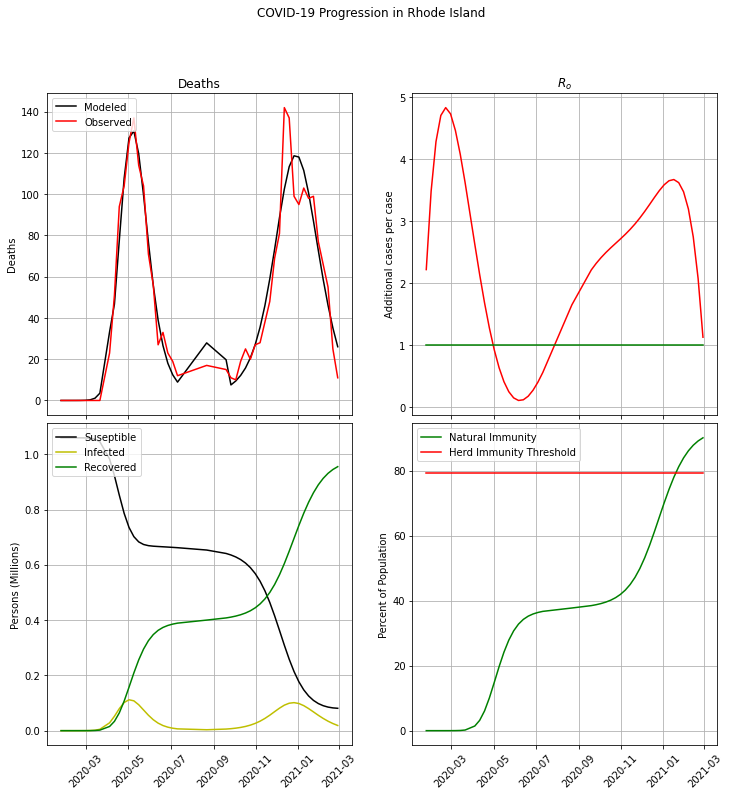

In [24]:
# Investigate the outliers

from SEIRv2 import SEIR
%matplotlib inline
seir = SEIR()
seir.plot_location("Rhode Island")

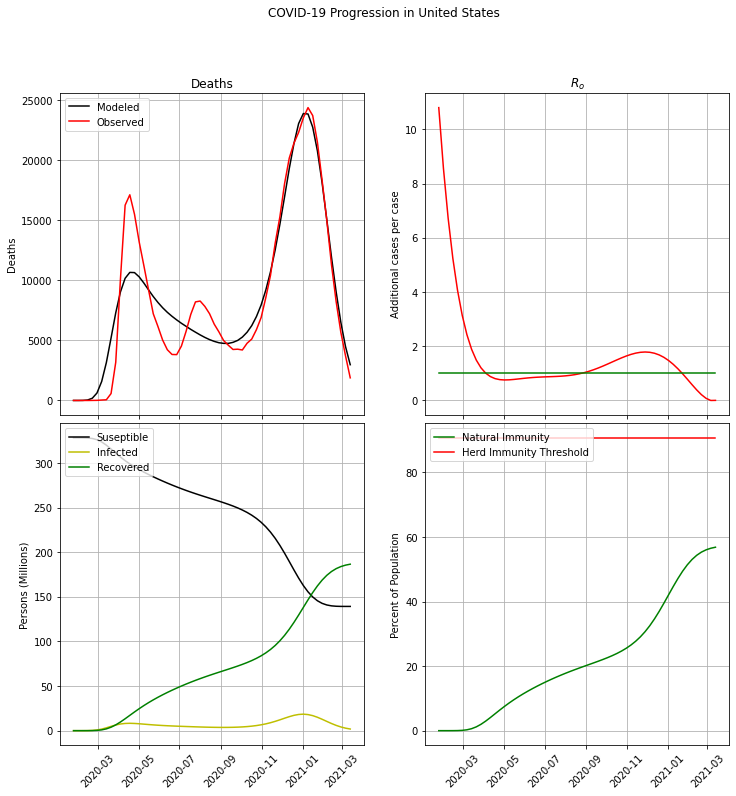

In [25]:
seir.plot_location("United States")